# Approach 1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

Download titanic data and prepare X, y.

Add Random Categorical and Numerical column to the data. Increases non-collinearity

In [ ]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

Create separate Categorical and Numerical columns

In [ ]:
categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

Data Preprocessing pipelines : 
    
    One Hot Enconding on all categorical columns
    Mean Value impution on all numerical columns

In [1]:
categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

print('Model Score from Approach 1 : ',  rf.score(X_train, y_train))

In [ ]:
%reset -f

# Approach 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns

df_train = pd.read_csv(r'F:\KaggleData\RF\train.csv')
df_test = pd.read_csv(r'F:\KaggleData\RF\test.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Fare contains Outliers that definitely need to be looked into.

In [7]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Age has significant null count, which needs to be handled via impution
However, % of nulls in Cabin is too high and the column should be dropped

In [9]:
df_train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
pd.crosstab(df_train['Sex'], df_train['Survived'])

Survived,0,1
Sex,,
female,81,233
male,468,109


<AxesSubplot:>

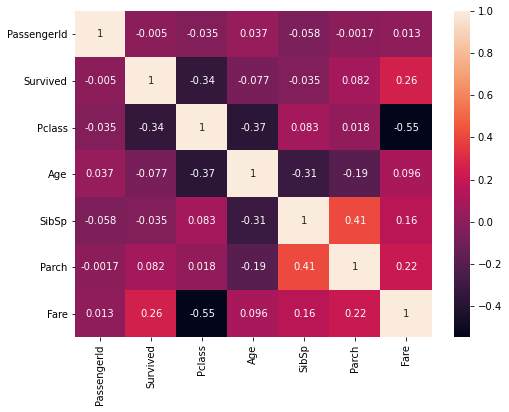

In [11]:
plt.figure(figsize = (8,6))

sns.heatmap(df_train.corr(), annot = True)

### Some visualizations

C:\Users\dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Survived', ylabel='count'>

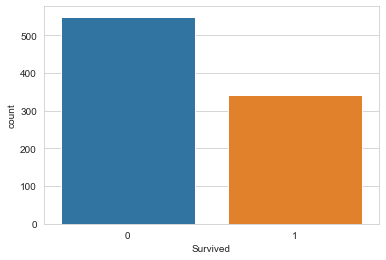

In [12]:
sns.set_style('whitegrid')

sns.countplot('Survived', data = df_train)

C:\Users\dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Survived', ylabel='count'>

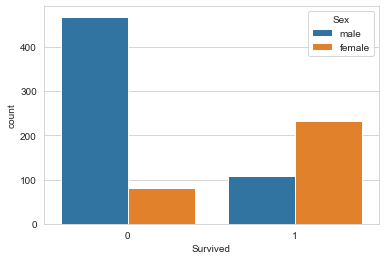

In [13]:
sns.set_style('whitegrid')

sns.countplot('Survived', hue = 'Sex', data = df_train)

C:\Users\dell\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

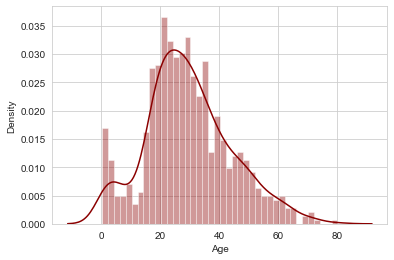

In [14]:
sns.distplot(df_train['Age'].dropna(), color = 'darkred', bins = 40)

### Transformations

In [15]:
#1. Impute Age with median and Fare with Mean values

df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())
df_test['Age'] = df_test['Age'].fillna(df_test['Age'].median())

df_train['Fare'] = df_train['Fare'].fillna(df_train['Fare'].mean())
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].mean())

In [16]:
#2. Drop columns - Cabin, Ticket, Name

df_train.drop(columns = ['Cabin', 'Ticket', 'Name'], axis = 1, inplace = True)
df_test.drop(columns = ['Cabin', 'Ticket', 'Name'], axis = 1, inplace = True)

In [17]:
#3. Replace Nulls in Embarked column with Mode

df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode())
df_test['Embarked'] = df_test['Embarked'].fillna(df_test['Embarked'].mode())

In [18]:
#4. One Hot Encoding - Sex, Embarked, 

sex_dummy = pd.get_dummies(df_train['Sex'], drop_first = True)
embarked_dummy = pd.get_dummies(df_train['Embarked'], drop_first = True)

df_train.drop(columns = ['Sex', 'Embarked'], axis = 1, inplace = True)
df_train = pd.concat([df_train, sex_dummy, embarked_dummy], axis = 1)

sex_dummy = pd.get_dummies(df_test['Sex'], drop_first = True)
embarked_dummy = pd.get_dummies(df_test['Embarked'], drop_first = True)

df_test.drop(columns = ['Sex', 'Embarked'], axis = 1, inplace = True)
df_test = pd.concat([df_test, sex_dummy, embarked_dummy], axis = 1)

In [19]:
#5. Scale columns - Fare and Age to transoform them between [-1,1]

scaler = StandardScaler()

df_train['Age_scaled'] = scaler.fit_transform(df_train[['Age']])
df_train['Fare_scaled'] = scaler.fit_transform(df_train[['Fare']])

df_test['Age_scaled'] = scaler.fit_transform(df_test[['Age']])
df_test['Fare_scaled'] = scaler.fit_transform(df_test[['Fare']])

df_train.drop(columns = ['Age', 'Fare'], axis = 1, inplace = True)
df_test.drop(columns = ['Age', 'Fare'], axis = 1, inplace = True)

In [20]:
df_train.head()

,PassengerId,Survived,Pclass,SibSp,Parch,male,Q,S,Age_scaled,Fare_scaled
0,1,0,3,1,0,1,0,1,-0.565736,-0.502445
1,2,1,1,1,0,0,0,0,0.663861,0.786845
2,3,1,3,0,0,0,0,1,-0.258337,-0.488854
3,4,1,1,1,0,0,0,1,0.433312,0.420730
4,5,0,3,0,0,1,0,1,0.433312,-0.486337


In [21]:
df_test.head()

,PassengerId,Pclass,SibSp,Parch,male,Q,S,Age_scaled,Fare_scaled
0,892,3,0,0,1,1,0,0.386231,-0.498407
1,893,3,1,0,0,0,1,1.371370,-0.513274
2,894,2,0,0,1,1,0,2.553537,-0.465088
3,895,3,0,0,1,0,1,-0.204852,-0.483466
4,896,3,1,1,0,0,1,-0.598908,-0.418471


Remove PassengerID and Survived columns from Train

Remove PassengerID from Test

In [22]:
X_train = df_train.iloc[:, 2:]
y_train = df_train['Survived']
X_test = df_test.iloc[:, 1:]

In [23]:
clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(clf.score(X_train, y_train))

0.9674523007856342


Such high scores generally indicate overfitting.
Let's apply RandomizedSearchCV for Hyperparameter tuning

In [28]:
#For Random Search or Grid Search, we need extimator objects which are simply put, instance on model class
#These instances are then trained on the parameters provided in param dict

estimator = RandomForestClassifier(n_jobs = -1)

params = [{'max_depth':[3,5,10,None],
              'n_estimators':[100,200,300],
              'max_features':[1,2,3],
              'criterion':['gini','entropy'],
              'bootstrap':[True,False],
              'min_samples_leaf':[1,2,3,4],
              'min_samples_split':[8,10,12]}]

rdm_srch = RandomizedSearchCV(estimator, param_distributions = params, n_iter = 40, cv = 10)

rdm_srch.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1),
                   n_iter=40,
                   param_distributions=[{'bootstrap': [True, False],
                                         'criterion': ['gini', 'entropy'],
                                         'max_depth': [3, 5, 10, None],
                                         'max_features': [1, 2, 3],
                                         'min_samples_leaf': [1, 2, 3, 4],
                                         'min_samples_split': [8, 10, 12],
                                         'n_estimators': [100, 200, 300]}])

In [31]:
print('Model Score from Approach 2 : ', rdm_srch.score(X_train, y_train))

0.8978675645342312

In [38]:
#Which combination gave the best result?
rdm_srch.best_params_

{'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 3,
 'max_depth': 10,
 'criterion': 'entropy',
 'bootstrap': False}

In [39]:
#Final Predictions
rdm_srch.predict(X_test)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## Things learnt - 

Approach 1
1. One Hot Encoding
2. SimpleImpute library
3. Pipelines in Scikit-Learn
4. Transformation
5. Handling Numerical and Categorical data in a single dataset using ColumnTransformer

Approach 2
1. Basic EDA - info, describe, isnull.sum(), value_counts, crosstab
2. SNS Plots - Countplot, distplot
3. Heatmaps
4. One Hot Encoding using pd.get_dummies (get_dummies DOESN'T RETURN DUMMY DATA :p )
5. Standard Scaling
6. RandomizedSearchCV